In [ ]:
#Project: Time series Competitive Analysis for Product Customer Sentiment Trends
#Course: CS439
#Names: ANNA NINASHVILI AND FABIAN RODAS INIGUEZ
#netIDs: an868, fr312

import requests
import pandas as pd
from datetime import datetime
import time
import random

In [ ]:

HEADERS = {"User-Agent": "Mozilla/5.0"}
BASE_URL = "https://www.reddit.com/r/CrohnsDisease/search.json"


def scrape(limit=4000, min_score=None):

    posts = []
    after = None

    query = "Stelara side effects"
    drug_name = "Stelara"

    while len(posts) < limit:
        params = {
            "q": query,
            "sort": "new",
            "restrict_sr": "on",
            "limit": 100,
            "after": after,
        }

        try:
            resp = requests.get(BASE_URL, params=params, headers=HEADERS, timeout=10)
        except Exception as e:
            print("Request failed:", e)
            break

        if resp.status_code != 200:
            print("Non-200 status code:", resp.status_code)
            break

        try:
            payload = resp.json()["data"]
            children = payload.get("children", [])
        except (ValueError, KeyError) as e:
            print("Bad JSON structure:", e)
            break

        if not children:

            break

        for item in children:
            d = item.get("data", {})

            title = d.get("title") or ""
            text = d.get("selftext") or ""
            combined = (title + " " + text).lower()

            # make sure Stelara is actually mentioned
            if "stelara" not in combined:
                continue

            score = d.get("score", 0)
            if min_score is not None and score < min_score:
                continue

            created_utc = d.get("created_utc")
            if created_utc is not None:
                created_at = datetime.fromtimestamp(created_utc, tz=timezone.utc)
            else:
                created_at = None

            posts.append(
                {
                    "drug": drug_name,
                    "title": title,
                    "text": text,
                    "created_utc": created_at,
                    "subreddit": d.get("subreddit", ""),
                    "score": score,
                    "id": d.get("id"),
                    "url": "https://reddit.com" + d.get("permalink", ""),
                }
            )

            if len(posts) >= limit:
                break


        after = payload.get("after")
        if not after:
            break

        time.sleep(random.uniform(0.5, 1.1))

    return pd.DataFrame(posts)


In [ ]:
Stelara_side_effects = scrape()

In [ ]:
Stelara_side_effects.tail()

In [ ]:
#repeat for
#Stelara_working
#Humira_working
#Skyrizi_working
#Rinvoq_working

#starting_Humira
#starting_Stelara
#starting_Rinvoq
#starting_Skyrizi

#experience_with_Stelara
#experience_with_Humira
#experience_with_Skyrizi
#experience_with_Rinvoq

#experience_Humira
#experience_Stelara
#experience_Rinvoq
#experience_Skyrizi

#stopping_Skyrizi
#stopping_Stelara
#stopping_Rinvoq
#stopping_Humira

In [ ]:
all_dfs = [ Stelara_working, Humira_working, Skyrizi_working, Rinvoq_working,
    starting_Humira, starting_Stelara, starting_Rinvoq, starting_Skyrizi,
    experience_with_Stelara, experience_with_Humira, experience_with_Skyrizi, experience_with_Rinvoq,
    experience_Humira, experience_Stelara, experience_Rinvoq, experience_Skyrizi,
    stopping_Skyrizi, stopping_Stelara, stopping_Rinvoq, stopping_Humira]

for df in all_dfs:
    df["created_date"] = pd.to_datetime(df["created_utc"]).dt.date

def align_cluster_by_common_start(dfs, date_col="created_date"):

    min_dates = {}
    for name, df in dfs.items():
        earliest_date = df[date_col].min()
        min_dates[name] = earliest_date

        common_start = max(min_dates.values())

    aligned_dfs = []
    for name, df in dfs.items():
        aligned_df = df[df[date_col] >= common_start].copy()
        aligned_df["drug"] = name

        print(name)
        print(len(df))
        print(" vs after ")
        print(len(aligned_df))
        aligned_dfs.append(aligned_df)

    final_aligned_df = pd.concat(aligned_dfs)
        return final_aligned_df, common_start

working_cluster = {
    "Humira": Humira_working,
    "Stelara": Stelara_working,
    "Skyrizi": Skyrizi_working,
    "Rinvoq": Rinvoq_working}

experience_with_cluster = {
    "Humira": experience_with_Humira,
    "Stelara": experience_with_Stelara,
    "Skyrizi": experience_with_Skyrizi,
    "Rinvoq": experience_with_Rinvoq }

experience_cluster = {
    "Humira": experience_Humira,
    "Stelara": experience_Stelara,
    "Skyrizi": experience_Skyrizi,
    "Rinvoq": experience_Rinvoq}

stopping_cluster = {
    "Humira": stopping_Humira,
    "Stelara": stopping_Stelara,
    "Skyrizi": stopping_Skyrizi,
    "Rinvoq": stopping_Rinvoq}

starting_cluster = {
    "Humira": starting_Humira,
    "Stelara": starting_Stelara,
    "Skyrizi": starting_Skyrizi,
    "Rinvoq": starting_Rinvoq}

In [ ]:
experience_with_aligned, exp_with_start = align_cluster_by_common_start(experience_with_cluster)
working_aligned, working_start = align_cluster_by_common_start(working_cluster)
experience_aligned, exp_start = align_cluster_by_common_start(experience_cluster)
stopping_aligned, stopping_start = align_cluster_by_common_start(stopping_cluster)
starting_aligned, starting_start = align_cluster_by_common_start(starting_cluster)


In [ ]:
drug = pd.concat([
    experience_aligned.drop_duplicates(subset=["text", "created_utc"]),
stopping_aligned.drop_duplicates(subset=["text", "created_utc"]),
experience_with_aligned.drop_duplicates(subset=["text", "created_utc"]),
working_aligned.drop_duplicates(subset=["text", "created_utc"]),
starting_aligned.drop_duplicates(subset=["text", "created_utc"])
]).drop_duplicates(subset=["text", "created_utc"])

In [ ]:
drug.to_csv("drug.csv") #save for jupyter restarts

In [ ]:
drug = pd.read_csv('drug.csv')

In [ ]:
#topic labeling

In [ ]:
import re

In [ ]:
words = ["humira", "stelara", "skyrizi", "rinvoq"]

In [ ]:
def context_only(text, keywords, span=1):
    text = "" if pd.isna(text) else str(text)

    sentences = re.split(r'(?<=[.!?])\s+', text)
    if not sentences:
        return ""

    keyword_indices = []
    for i, sentence in enumerate(sentences):
        lowered = sentence.lower()



        for k in keywords:
            if k.lower() in lowered:
                keyword_indices.append(i)
                break

    keep_indices = set()
    for index in keyword_indices:
        start = index - span
        end = index + span
        for j in range(start, end + 1):
            if 0 <= j < len(sentences):
                keep_indices.add(j)

    filtered_sentences = [sentences[j] for j in sorted(keep_indices)]
    return " ".join(filtered_sentences)


In [ ]:
drug["text"] = drug["text"].apply(
    lambda x: context_only(x, words, span=1))

In [ ]:
drug["text + title"] = drug['title'] + " " + drug['text']

In [ ]:
#split by whether the drug mentions 2 drugs

In [ ]:
drug['number_match'] = drug['text + title'].apply(lambda x: sum(w in str(x).lower() for w in words))
drug_multiple = drug[drug['number_match'] > 1]
drug_one = drug[drug['number_match'] == 1]

In [ ]:
len(drug_multiple)

360

In [ ]:
drug_multiple.to_csv("drug_multiple.csv")

In [ ]:
drug_one.head()

,Unnamed: 0,drug,title,text,created_utc,subreddit,score,id,url,created_date,text + title,number_match
0,0,Humira,"My Crohn's Story: Recklessness, Denial &amp; S...","This time though, they had to go in with a 16G...",2025-12-04 04:34:41,CrohnsDisease,5,1pdqr63,https://reddit.com/r/CrohnsDisease/comments/1p...,2025-12-04,"My Crohn's Story: Recklessness, Denial &amp; S...",1
2,2,Humira,Dangers of getting tattooed?,"Hi all, I would like to get more tattoos (got ...",2025-12-03 08:58:28,CrohnsDisease,1,1pczaoa,https://reddit.com/r/CrohnsDisease/comments/1p...,2025-12-03,"Dangers of getting tattooed? Hi all, I would l...",1
3,3,Humira,Anyone with proctitis continuously gaslit by G...,Diagnosed with Crohn’s colitis for 11 years no...,2025-12-02 17:24:03,CrohnsDisease,4,1pcegm3,https://reddit.com/r/CrohnsDisease/comments/1p...,2025-12-02,Anyone with proctitis continuously gaslit by G...,1
4,4,Humira,Switching from Humira to Hyrimoz - what was yo...,Due to some upcoming changes in my insurance c...,2025-11-30 20:32:59,CrohnsDisease,2,1pasnow,https://reddit.com/r/CrohnsDisease/comments/1p...,2025-11-30,Switching from Humira to Hyrimoz - what was yo...,1
10,10,Humira,Tremfya,"Took 4 months of procedures and tests, but I w...",2025-11-01 07:27:53,CrohnsDisease,5,1olhrpa,https://reddit.com/r/CrohnsDisease/comments/1o...,2025-11-01,"Tremfya Took 4 months of procedures and tests,...",1


In [ ]:
drug_one["text + title"] = drug_one["text + title"].str.lower()

/var/folders/pf/s92c2ky926x94g0fv3rkqb8r0000gn/T/ipykernel_51115/777937277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_one["text + title"] = drug_one["text + title"].str.lower()


In [ ]:
drug_one = drug_one.reset_index()

In [ ]:
label_map = { "treatment_failure":
            [
        r"didn[’']?t work", r"(humira|stelara|skyrizi|rinvoq) failed", r"stopped working",
                r"no response",
        r"developed antibodies", r"tried .{1,12} (humira|stelara|skyrizi|rinvoq)[s]?",
                r"not work"],

    "negative_side_effects":
         [
        r"gave me .*", r"made symptoms worse", r"bad reaction", r"pain", r"developed", r"started develop"],

    "insurance_cost_access":
         [
        r"insurance won[’']?t cover", r"can[’']?t afford", r"biosimilar.*insurance",
        r"copay", r"prior auth", r"formulary", r"coverage", r"too expensive"],

        "switching_off": [
        r"switch(ing)? (from|off)", r"stopping", r"coming off", r"anyone stop",
        r"getting off", r"try another drug", r"experience"],

            "new_start": [
        r"starting", r"first dose", r"about to begin", r"adding", r"\bfirst\b"],

            "switching_to": [
        r"switching to (humira|stelara|skyrizi|rinvoq)", r"move (me)? to (humira|stelara|skyrizi|rinvoq)",
        r"considering .* vs", r"experience with", r"trying (humira|stelara|skyrizi|rinvoq)"],

    "treatment_effective": [
        r"remission", r"works", r"feel better", r"been working", r"effective "]
}

In [ ]:
labeled = []

for i in range(len(drug_one)):
    text = drug_one.iloc[i]['text + title']
    labels_row = {}
    for drug in words:
        if drug not in text:
            continue
        matched_labels = []
        for label, strings in label_map.items():
            for string_i in strings:
                if re.search(string_i, text):
                    matched_labels.append(label)
                    break
        if matched_labels:
            labels_row[drug] = matched_labels #dict val to key

    labeled.append(labels_row if labels_row else None)


drug_one['labeled_topics'] = labeled
drug_one_unlabeled = drug_one[drug_one['labeled_topics'].isna()].copy()
drug_one_labeled = drug_one[drug_one["labeled_topics"].notna()].copy()

In [ ]:
drug_one_labeled.to_csv('drug_one_labeled.csv')

In [ ]:
drug_one_unlabeled.to_csv('drug_one_unlabeled.csv')

In [ ]:
#manual entry on mac's numbers application

In [ ]:
drug_multiple = pd.read_csv('drug_multiple.csv')

In [ ]:
drug_one_unlabeled = pd.read_csv('drug_one_unlabeled.csv')

In [ ]:
drug_one_labeled = pd.read_csv('drug_one_labeled.csv')

In [ ]:
drug1 = pd.concat([drug_one_unlabeled, drug_one_labeled, drug_multiple])

In [ ]:
drug1["created_date"] = pd.to_datetime(drug1["created_date"])

In [ ]:
cutoff_date = datetime(2025, 4, 17)
drug2 = drug1[drug1['created_date'] >= cutoff_date]
drug_all_labeled = drug2

In [ ]:
drug_all_labeled = drug_all_labeled.drop_duplicates(subset="id")
cols_to_drop = [col for col in ["Unnamed: 0", "index", "number_match"] if col in drug_all_labeled.columns]
drug_all_labeled = drug_all_labeled.drop(columns=cols_to_drop)

In [ ]:
len(drug_all_labeled)

923

In [ ]:
drug_all_labeled[['created_date', 'score', 'id', 'text + title', 'labeled_topics']].head(20)

In [ ]:
drug_subset = drug_all_labeled[['created_date', 'score', 'id', 'text + title', 'labeled_topics']]
len(drug_subset)

923

In [ ]:
drug_subset.to_csv('drug_subset.csv') #save in case jupyter has to restart

In [ ]:
#explosion code was not working properly which was probably because it wasnt correctly interpreting all the labeled_topic column values as dictionaries
#so force it to dict
#apparently bc of the single quotes

In [ ]:
import json

def convert_to_dict(x):
    if isinstance(x, str):
        try:
            return json.loads(x.replace("'", '"'))
        except json.JSONDecodeError:
            return {}
    return x

In [ ]:
drug_subset1 = pd.read_csv("drug_subset.csv")
drug_subset1["labeled_topics"] = drug_subset1["labeled_topics"].apply(convert_to_dict) #on all the rows

In [ ]:
type(drug_subset1.iloc[0, -1]) #is a dictionary yayyyy

dict

In [ ]:
new_rows = []

for index, row in drug_subset1.iterrows():
    topic_dict = row["labeled_topics"]
    if not isinstance(topic_dict, dict):
        continue

    for drug in topic_dict:
        labels = topic_dict[drug]
        if isinstance(labels, str):
            labels = [labels]

        for label in labels:
            row_copy = row.copy()
            row_copy["drug"] = drug
            row_copy["topic"] = label
            new_rows.append(row_copy)

drug_all_exploded = pd.DataFrame(new_rows)
if "labeled_topics" in drug_all_exploded.columns:
    drug_all_exploded.drop(columns=["labeled_topics"], inplace=True)


In [ ]:
len(drug_all_exploded)

1417

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
drug_all_exploded[["created_date", "drug", "topic", "score", "id"]].head(20)

,created_date,drug,topic,score,id
0,2025-11-19,Skyrizi,treatment_failure,2,1p1m8hj
1,2025-11-19,Stelara,treatment_failure,10,1p0wxgh
2,2025-11-14,Skyrizi,new_start,17,1owlbk8
3,2025-11-14,Skyrizi,Other,1,1oxb6qo
4,2025-11-13,Humira,insurance_cost_access,1,1ow1mof
5,2025-11-13,Skyrizi,treatment_effective,8,1ovqc3d
6,2025-11-11,Skyrizi,new_start,2,1oujfyk
7,2025-11-11,Stelara,treatment_effective,12,1oufwf2
8,2025-11-08,Skyrizi,new_start,6,1orus1q
9,2025-11-08,Skyrizi,treatment_failure,4,1orzu0d


In [ ]:
drug_all_exploded["created_date"] = pd.to_datetime(drug_all_exploded["created_date"])
drug_all_exploded2 = drug_all_exploded
drug_all_exploded2["month"] = drug_all_exploded2["created_date"].dt.to_period("M")

grouped = drug_all_exploded2.groupby(["drug", "topic", "month"])

results = []

for group_values, group_df in grouped:
    drug_val = group_values[0]
    topic_val = group_values[1]
    month_val = group_values[2]

    n_posts = group_df["id"].nunique()
    total_score = group_df["score"].sum()
    mean_score = group_df["score"].mean() #prob  not going to be used

    results.append({ "drug": drug_val, "topic": topic_val,"month": month_val,"n_posts": n_posts, "total_score": total_score, "mean_score": mean_score})



In [ ]:
month_data = pd.DataFrame(results)
month_data["month"] = month_data["month"].dt.to_timestamp() #have to convert AGAIN .


In [ ]:
month_data.head()

,drug,topic,month,n_posts,total_score,mean_score
0,Humira,Other,2025-04-01,1,13,13.000000
1,Humira,Other,2025-05-01,2,56,28.000000
2,Humira,Other,2025-06-01,3,47,15.666667
3,Humira,Other,2025-07-01,4,90,22.500000
4,Humira,Other,2025-08-01,1,1,1.000000


In [ ]:
drug_all_exploded2['created_date'].max()

In [ ]:
month_data1 = month_data[(month_data['topic'] != "Other") & (month_data['topic'] != "other")]

In [ ]:
monthly_agg_no_april = month_data1[month_data1['month'] != "2025-04-01"]

In [ ]:
monthly_agg_no_december = monthly_agg_no_april[monthly_agg_no_april['month'] != "2025-12-01"]

In [ ]:
def topic_corr__drug(df, drug_name):
    sub = df[df["drug"] == drug_name]

    wide = sub.pivot_table(index="month",  columns="topic", values="n_posts", fill_value=0 )
    return wide.corr()

In [ ]:
humira_corr = topic_corr__drug(monthly_agg_no_december, "Humira")
stelara_corr = topic_corr__drug(monthly_agg_no_december, "Stelara")
skyrizi_corr = topic_corr__drug(monthly_agg_no_december, "Skyrizi")
rinvoq_corr = topic_corr__drug(monthly_agg_no_december, "Rinvoq")


In [ ]:
humira_corr

topic,insurance_cost_access,negative_side_effects,new_start,switching_off,switching_to,treatment_effective,treatment_failure
topic,,,,,,,
insurance_cost_access,1.000000,-0.129719,-0.214599,-0.136444,-0.641689,0.408638,-0.492669
negative_side_effects,-0.129719,1.000000,0.357910,-0.091025,0.535108,0.054522,0.348960
new_start,-0.214599,0.357910,1.000000,0.225880,-0.019672,0.566247,0.896155
switching_off,-0.136444,-0.091025,0.225880,1.000000,-0.012508,-0.286746,-0.012804
switching_to,-0.641689,0.535108,-0.019672,-0.012508,1.000000,-0.569388,0.110398
treatment_effective,0.408638,0.054522,0.566247,-0.286746,-0.569388,1.000000,0.526636
treatment_failure,-0.492669,0.348960,0.896155,-0.012804,0.110398,0.526636,1.000000


In [ ]:
stelara_corr

topic,insurance_cost_access,negative_side_effects,new_start,switching_off,switching_to,treatment_effective,treatment_failure
topic,,,,,,,
insurance_cost_access,1.000000,0.197789,0.509525,0.175035,-0.366618,-0.250434,-0.235120
negative_side_effects,0.197789,1.000000,0.372104,-0.230089,0.388223,0.118341,-0.106146
new_start,0.509525,0.372104,1.000000,0.214043,-0.448322,0.380304,0.383358
switching_off,0.175035,-0.230089,0.214043,1.000000,-0.046203,-0.495074,0.316065
switching_to,-0.366618,0.388223,-0.448322,-0.046203,1.000000,-0.324047,0.022569
treatment_effective,-0.250434,0.118341,0.380304,-0.495074,-0.324047,1.000000,0.538062
treatment_failure,-0.235120,-0.106146,0.383358,0.316065,0.022569,0.538062,1.000000


In [ ]:
rinvoq_corr

topic,insurance_cost_access,negative_side_effects,new_start,switching_off,switching_to,treatment_effective,treatment_failure
topic,,,,,,,
insurance_cost_access,1.000000,-0.265747,4.830459e-01,3.535534e-01,-0.066667,0.883883,-0.010336
negative_side_effects,-0.265747,1.000000,-4.621248e-01,3.006584e-01,0.340156,-0.432196,0.191179
new_start,0.483046,-0.462125,1.000000e+00,-2.889245e-17,-0.241523,0.256174,0.089872
switching_off,0.353553,0.300658,-2.889245e-17,1.000000e+00,0.636396,0.458333,0.073088
switching_to,-0.066667,0.340156,-2.415229e-01,6.363961e-01,1.000000,0.106066,0.082690
treatment_effective,0.883883,-0.432196,2.561738e-01,4.583333e-01,0.106066,1.000000,-0.226573
treatment_failure,-0.010336,0.191179,8.987170e-02,7.308817e-02,0.082690,-0.226573,1.000000


In [ ]:
skyrizi_corr

topic,insurance_cost_access,negative_side_effects,new_start,switching_off,switching_to,treatment_effective,treatment_failure
topic,,,,,,,
insurance_cost_access,1.000000,0.415134,-0.474515,0.484123,0.046265,-0.458258,0.371161
negative_side_effects,0.415134,1.000000,-0.455292,0.055442,0.153648,-0.043733,0.508215
new_start,-0.474515,-0.455292,1.000000,-0.331133,0.522131,0.117541,-0.215237
switching_off,0.484123,0.055442,-0.331133,1.000000,-0.238909,-0.788811,0.416667
switching_to,0.046265,0.153648,0.522131,-0.238909,1.000000,0.367486,-0.238909
treatment_effective,-0.458258,-0.043733,0.117541,-0.788811,0.367486,1.000000,-0.394405
treatment_failure,0.371161,0.508215,-0.215237,0.416667,-0.238909,-0.394405,1.000000


In [ ]:
#cant do line charts before filling missing months where no posts

In [ ]:
months = pd.date_range("2025-05-01", "2025-11-01", freq="MS")

drugs = monthly_agg_no_december["drug"].unique()
topics = monthly_agg_no_december["topic"].unique()

rows = []
for d in drugs:
    for t in topics:
        for m in months:
            rows.append({"drug": d, "topic": t, "month": m})

all_combos = pd.DataFrame(rows)


In [ ]:
len(monthly_agg_no_december)

326

In [ ]:
filled_df = all_combos.merge(monthly_agg_no_december, on=["drug", "topic", "month"], how="left") #putting in all the matching from monthly df to filled

num_cols = filled_df.select_dtypes(include="number").columns
filled_df[num_cols] = filled_df[num_cols].fillna(0) #putting 0 where there were no values from monthly df

print(len(filled_df))

392


In [ ]:
filled_df

,drug,topic,month,n_posts,total_score,mean_score
0,Humira,insurance_cost_access,2025-05-01,2.0,3.0,1.500000
1,Humira,insurance_cost_access,2025-06-01,2.0,108.0,54.000000
2,Humira,insurance_cost_access,2025-07-01,1.0,1.0,1.000000
3,Humira,insurance_cost_access,2025-08-01,3.0,8.0,2.666667
4,Humira,insurance_cost_access,2025-09-01,2.0,6.0,3.000000
5,Humira,insurance_cost_access,2025-10-01,1.0,1.0,1.000000
6,Humira,insurance_cost_access,2025-11-01,3.0,75.0,25.000000
7,Humira,negative_side_effects,2025-05-01,3.0,8.0,2.666667
8,Humira,negative_side_effects,2025-06-01,6.0,27.0,4.500000
9,Humira,negative_side_effects,2025-07-01,2.0,6.0,3.000000


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
filled_df['month'] = pd.to_datetime(filled_df['month']) #new df convert
filled_df = filled_df.sort_values('month')

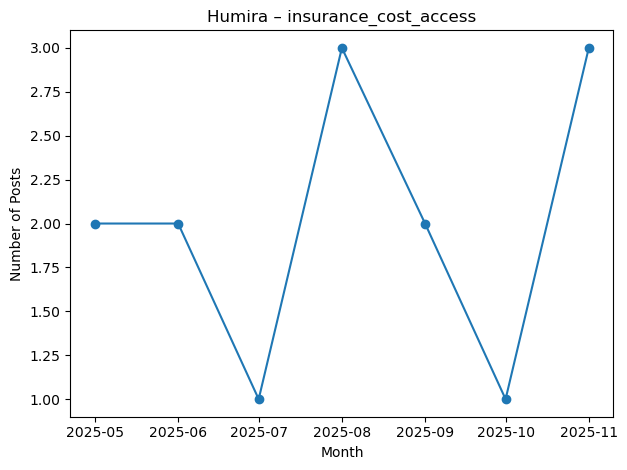

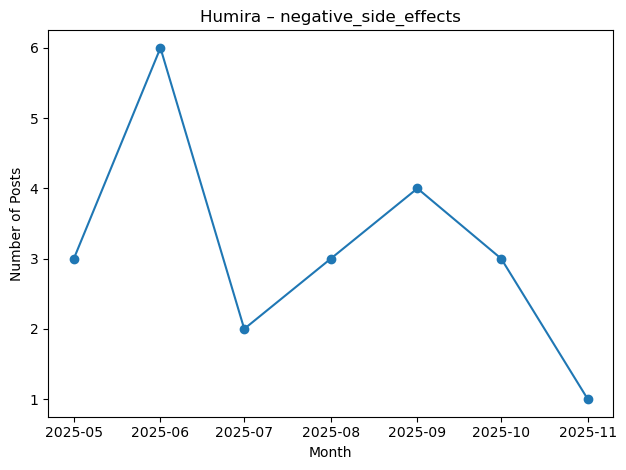

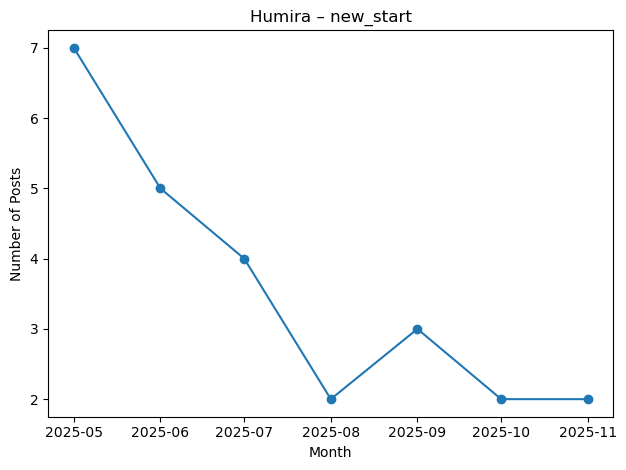

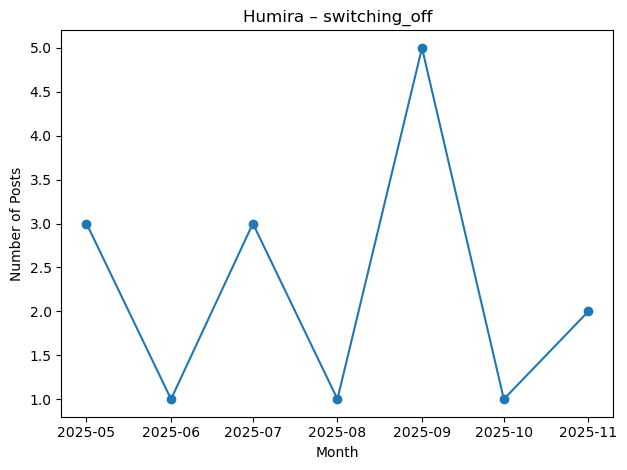

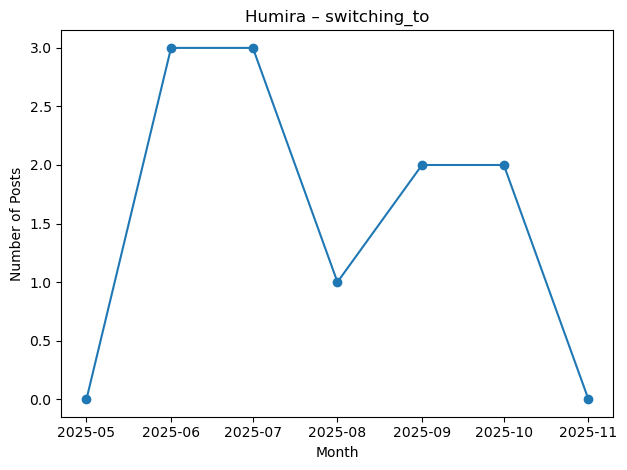

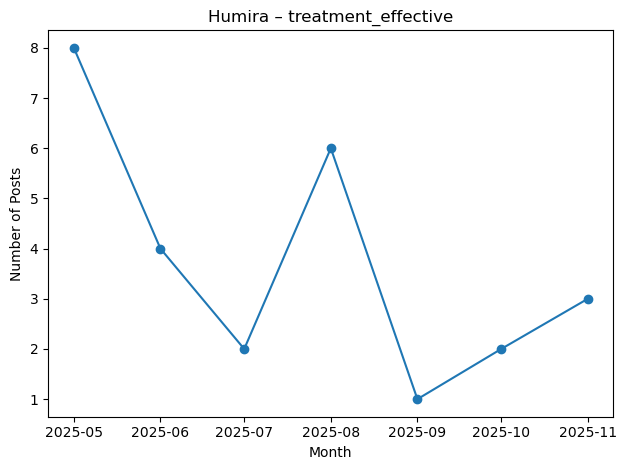

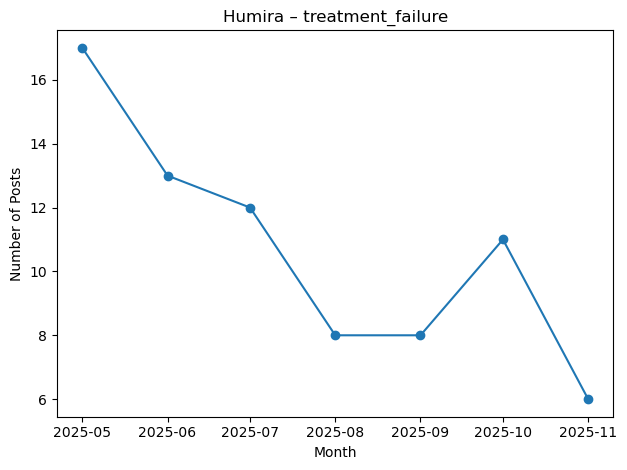

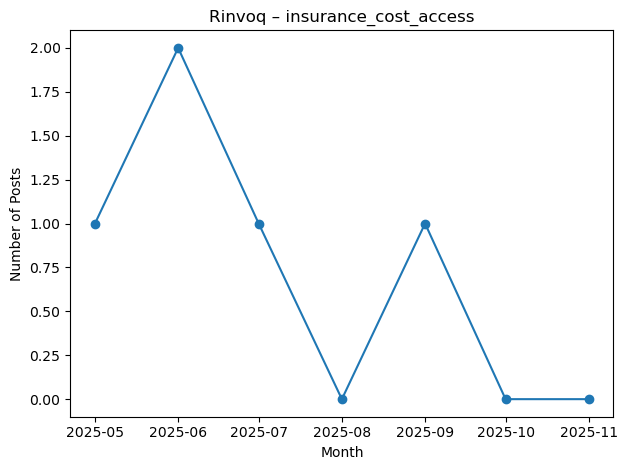

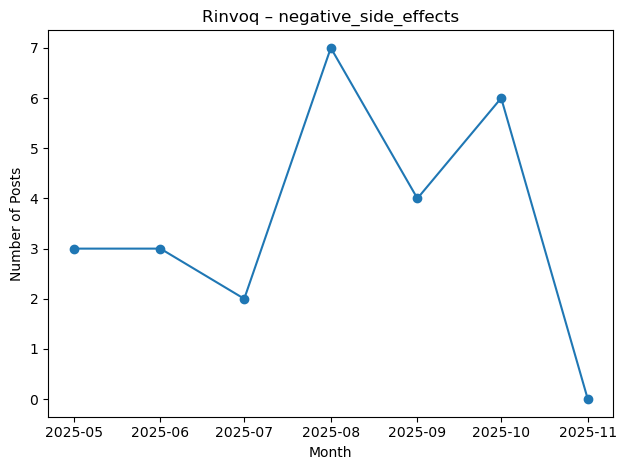

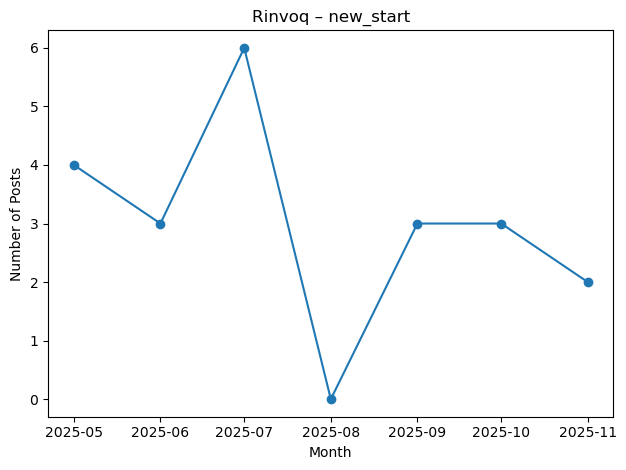

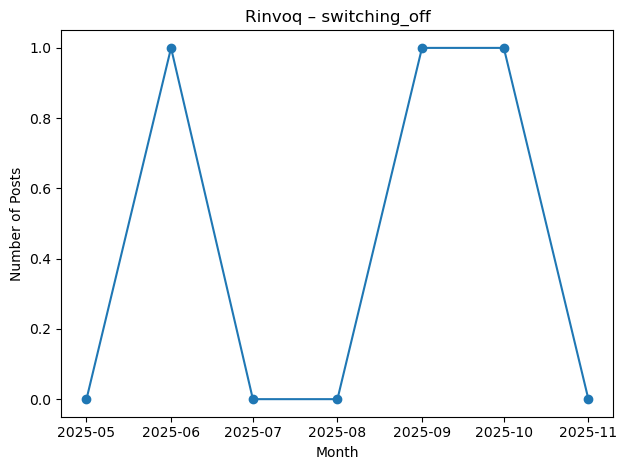

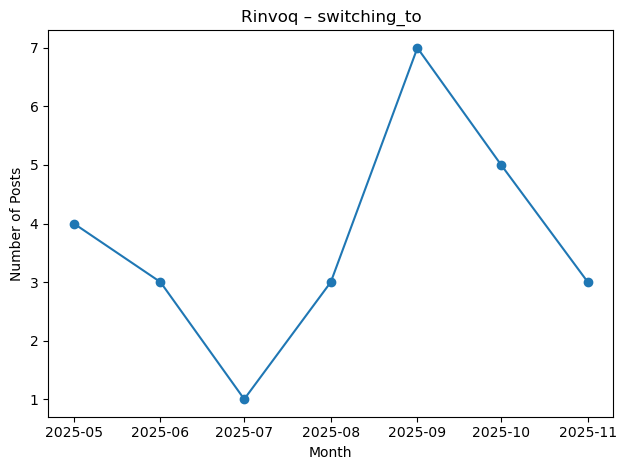

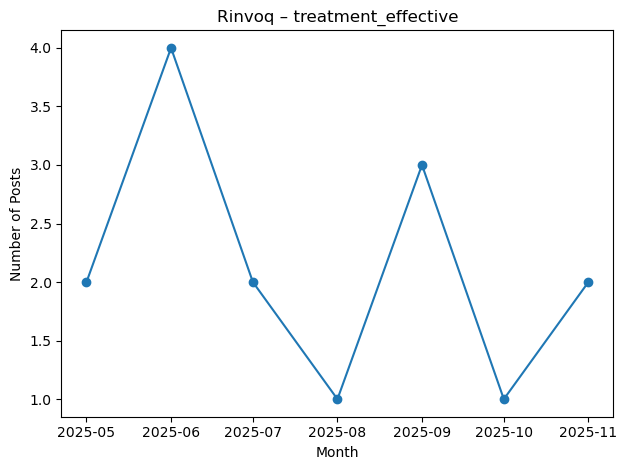

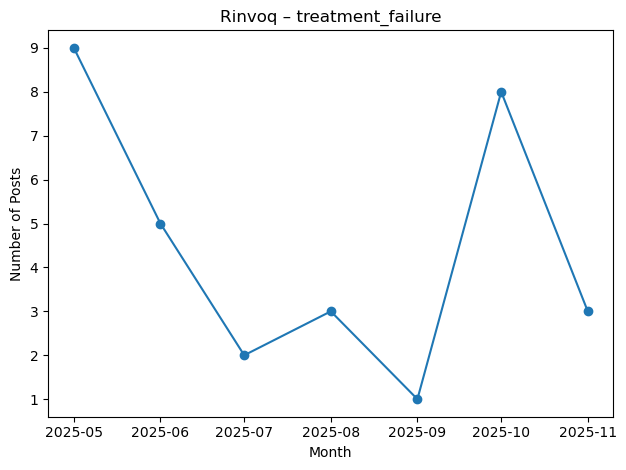

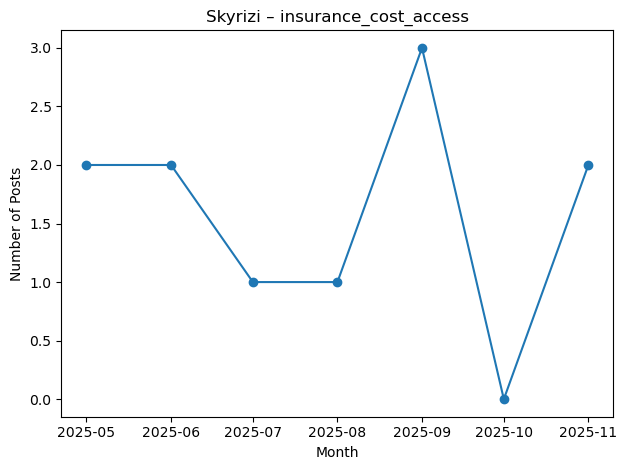

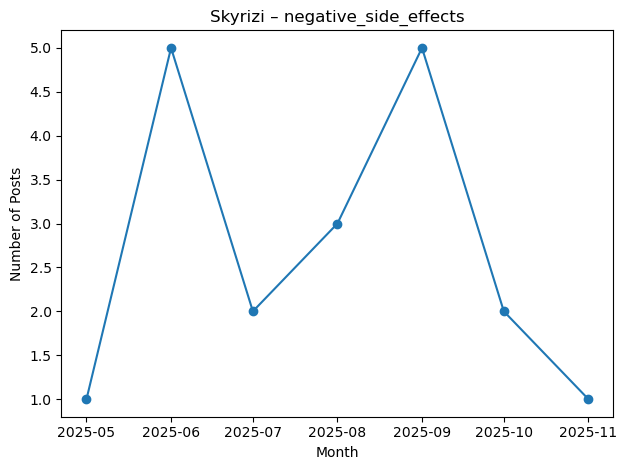

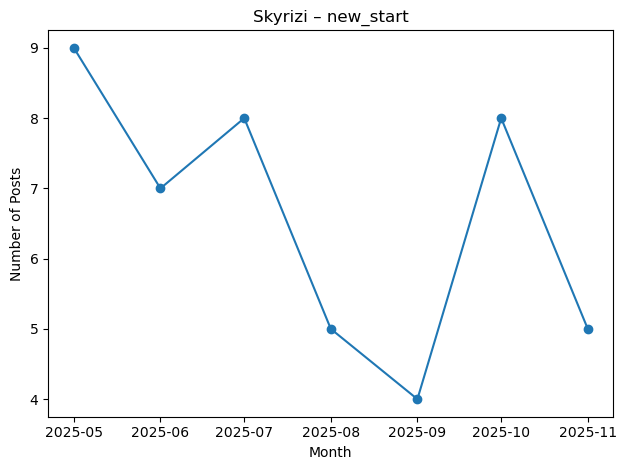

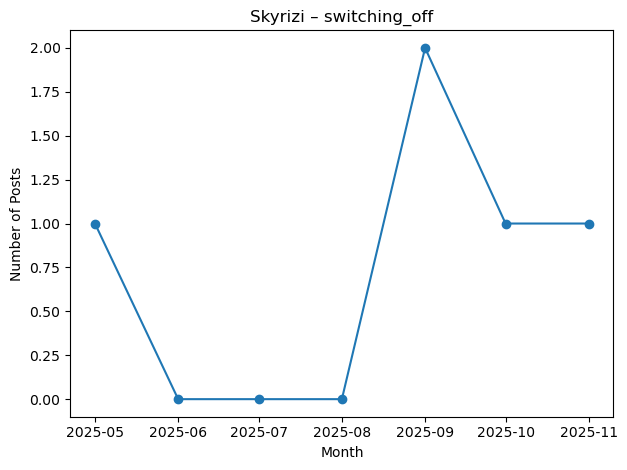

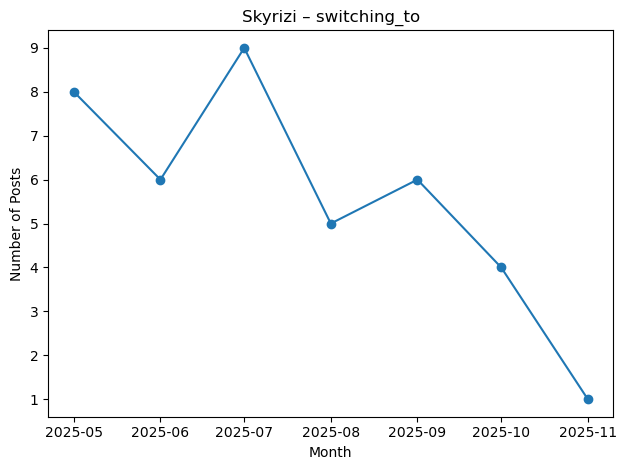

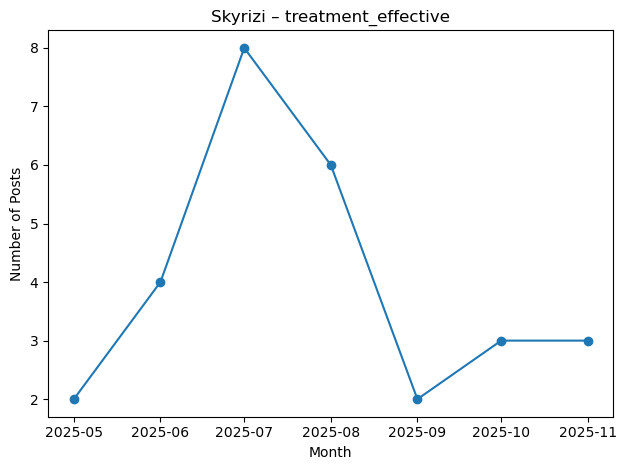

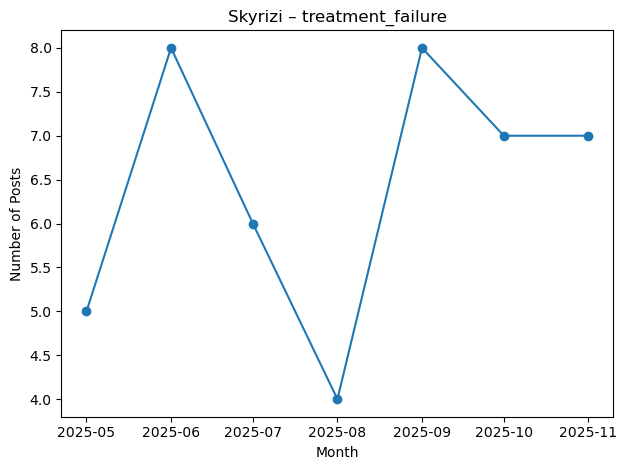

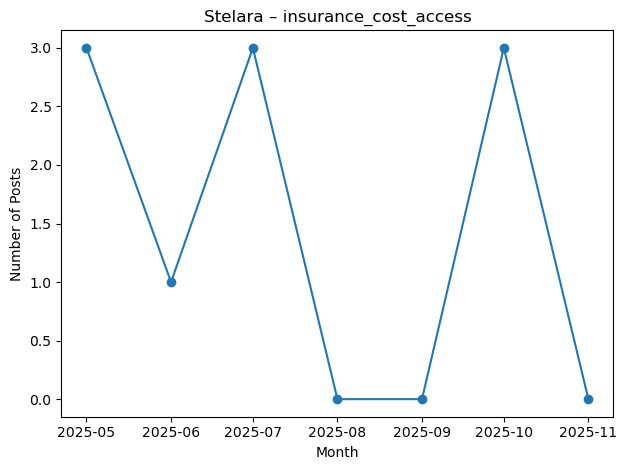

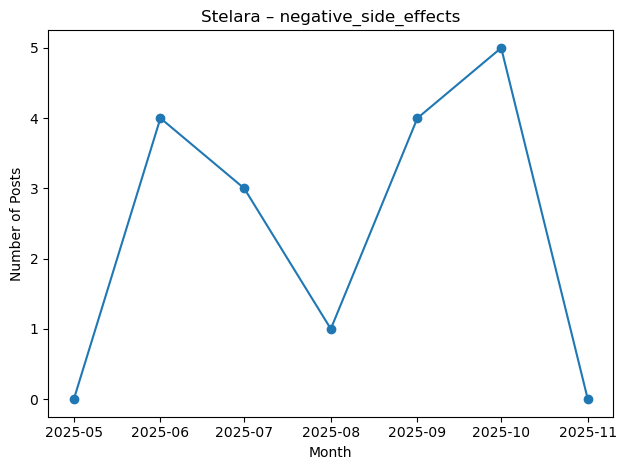

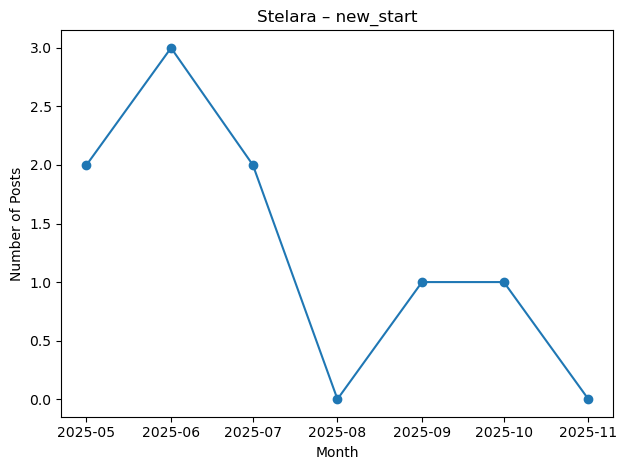

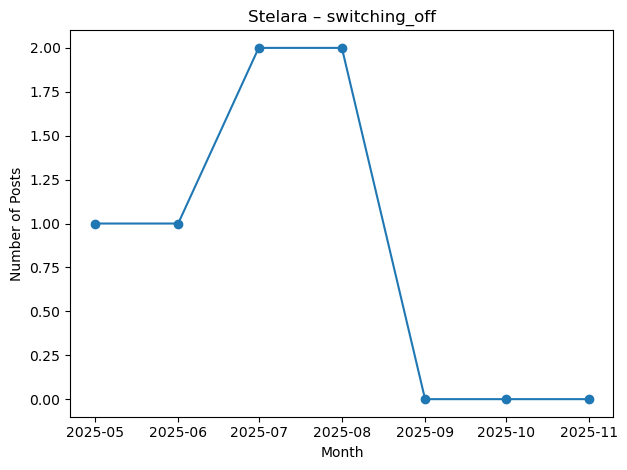

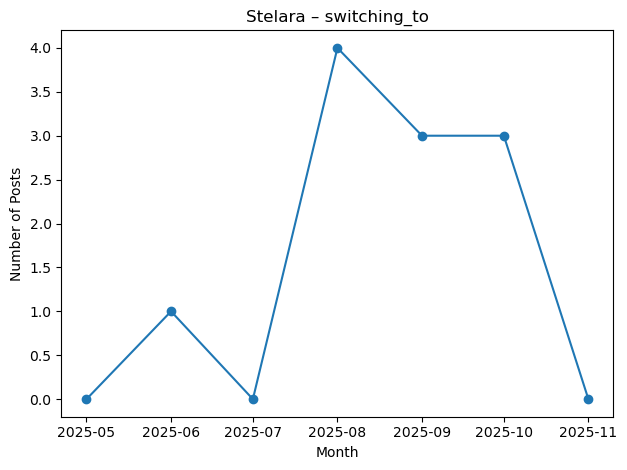

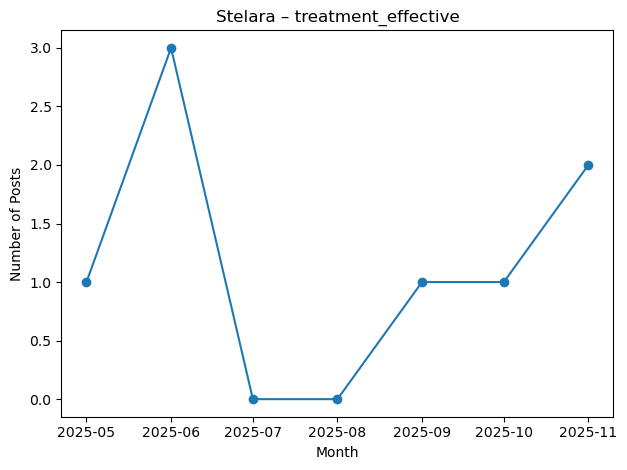

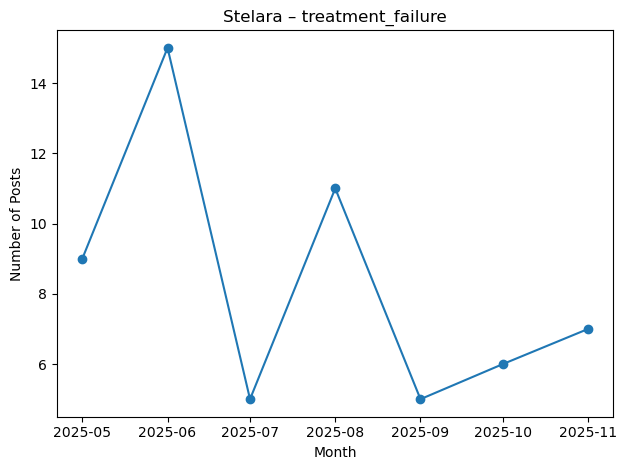

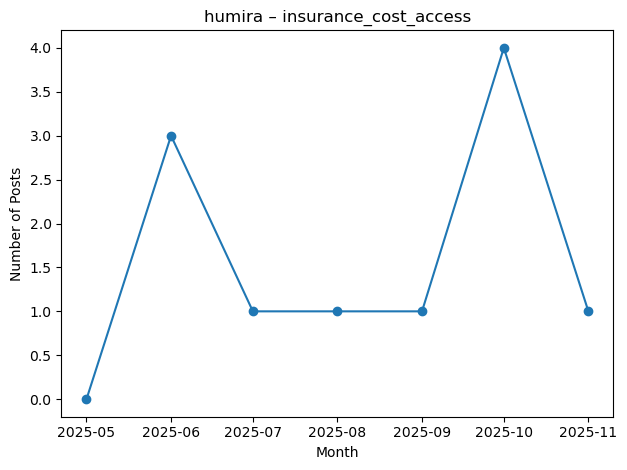

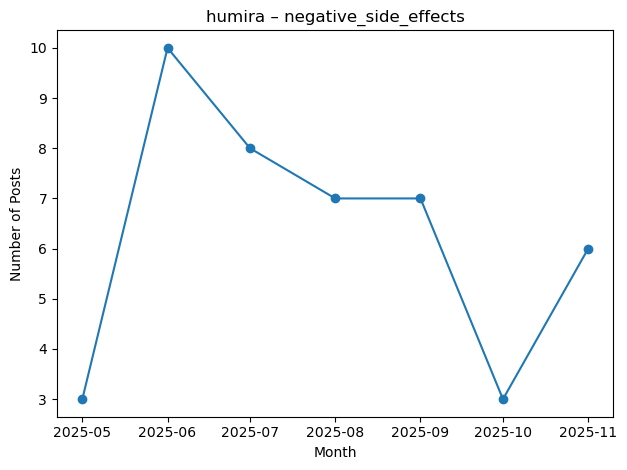

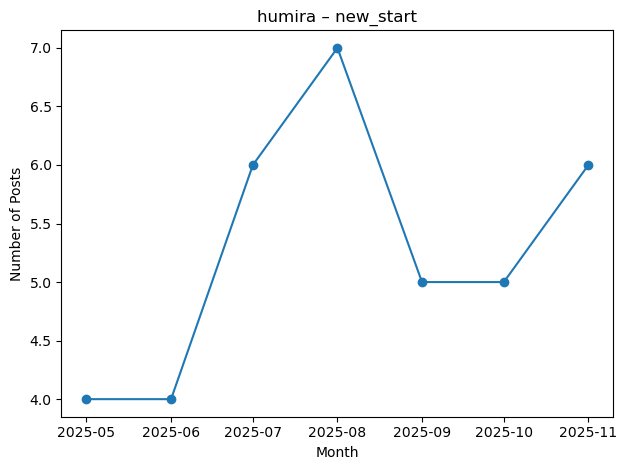

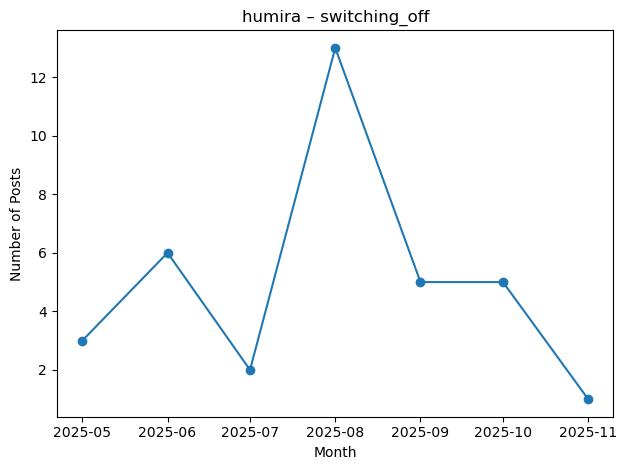

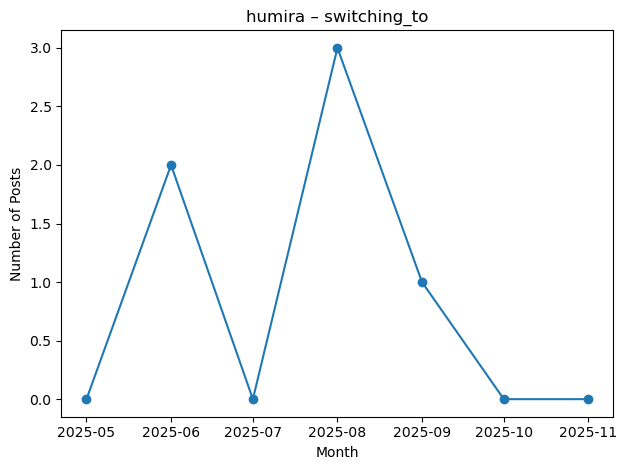

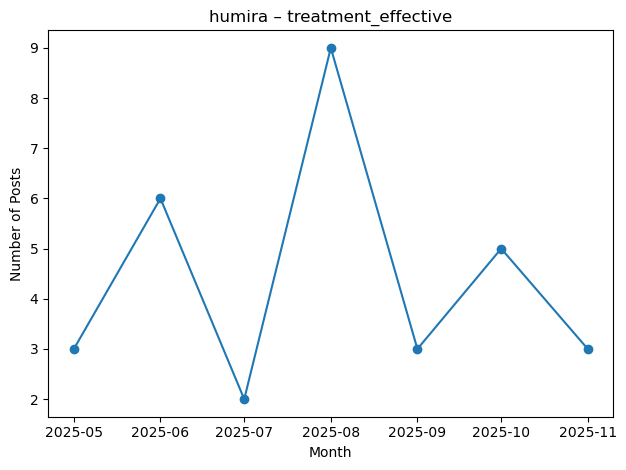

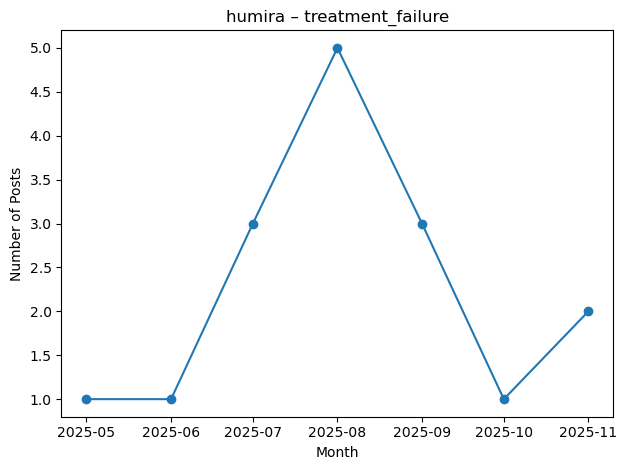

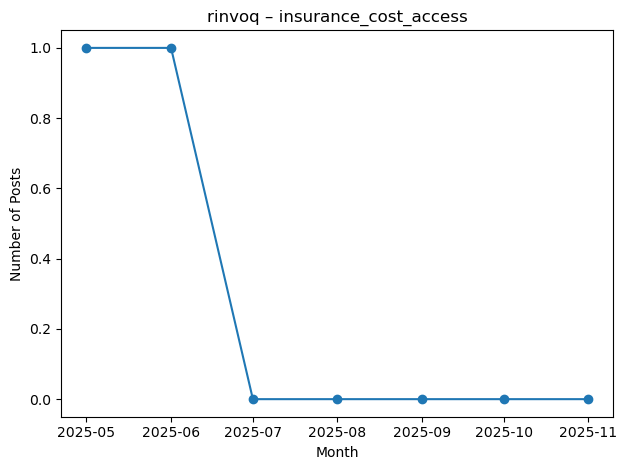

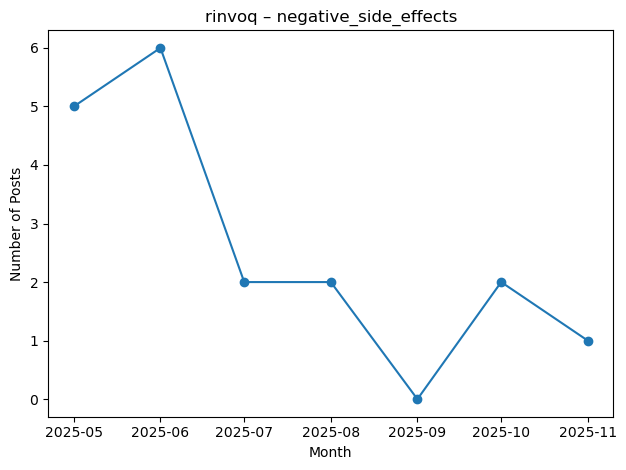

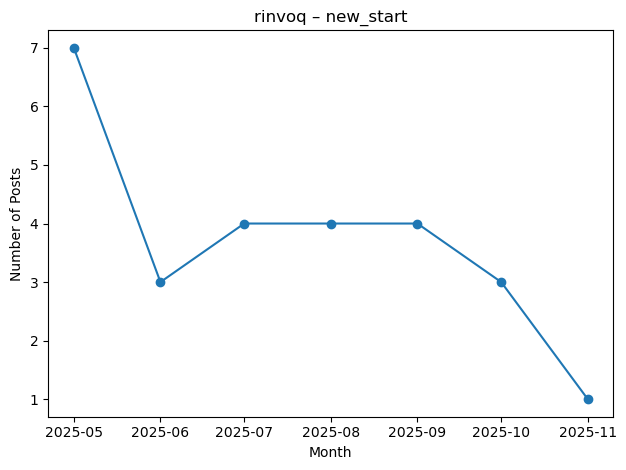

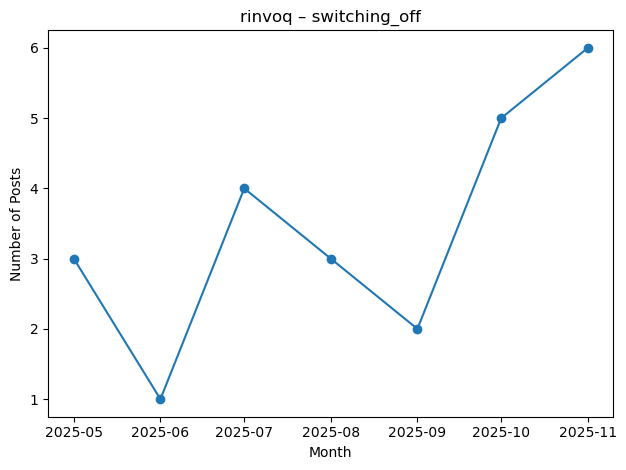

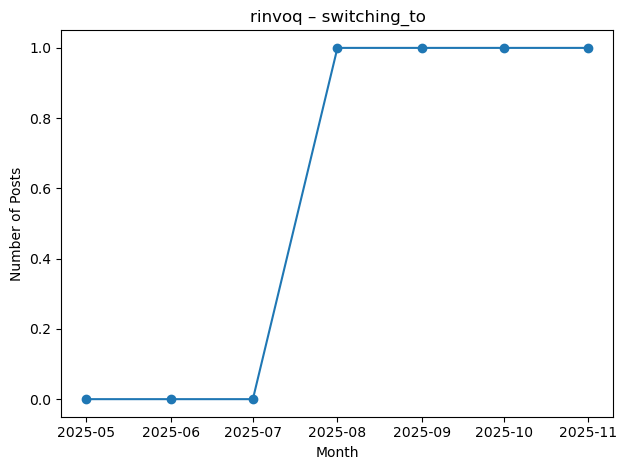

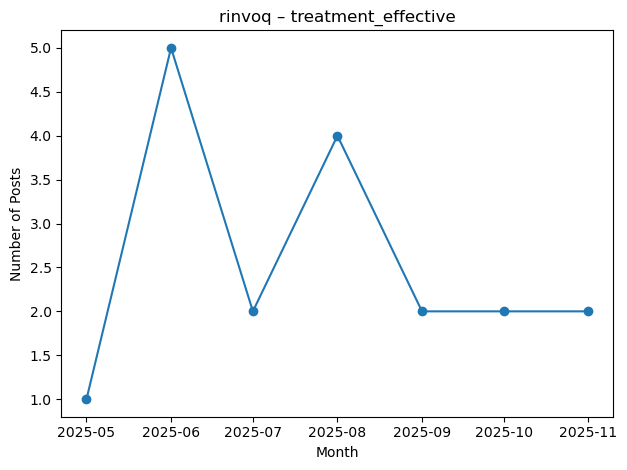

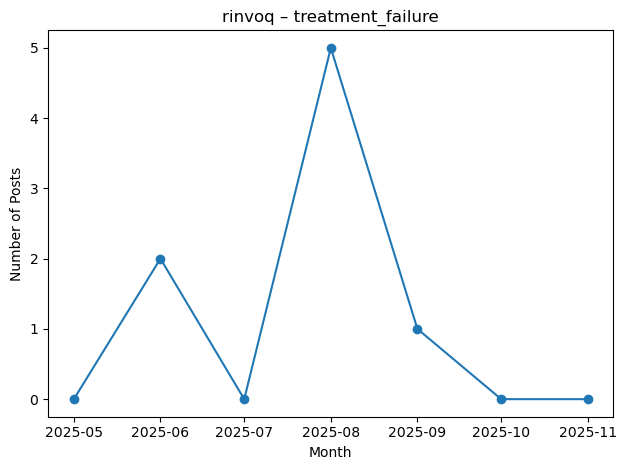

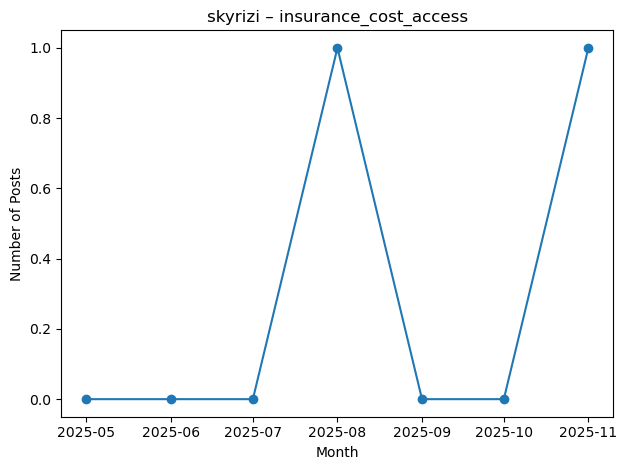

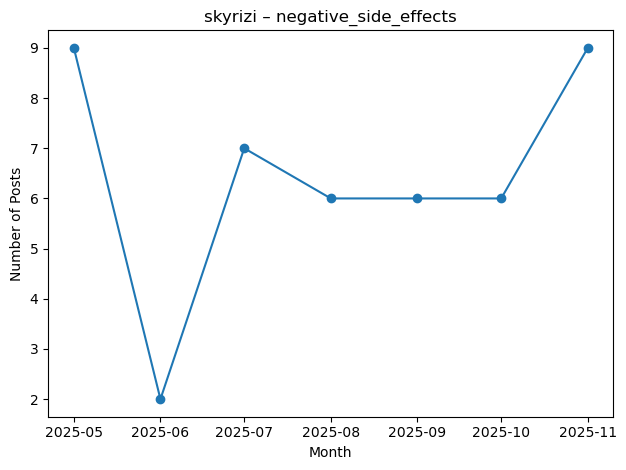

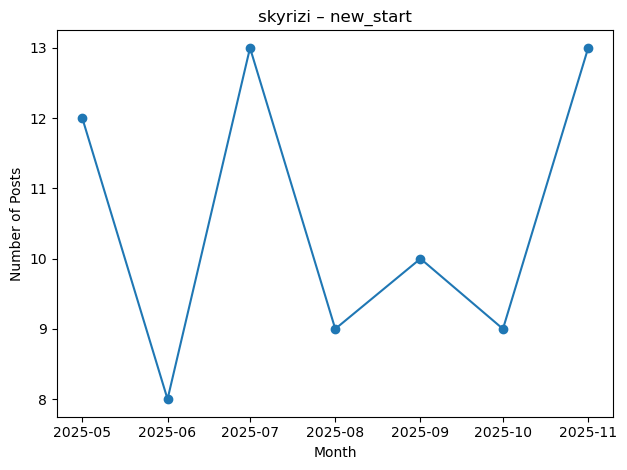

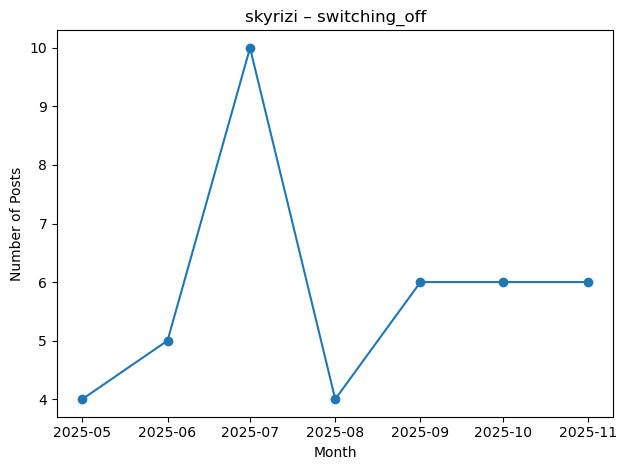

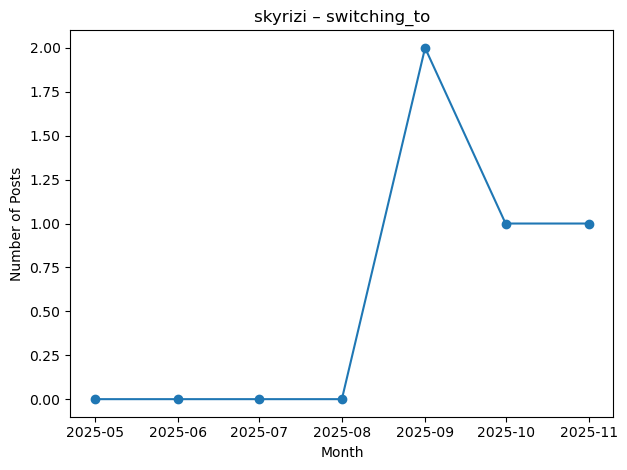

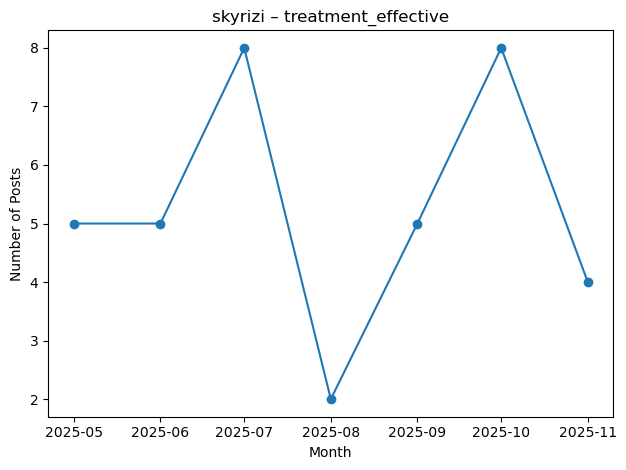

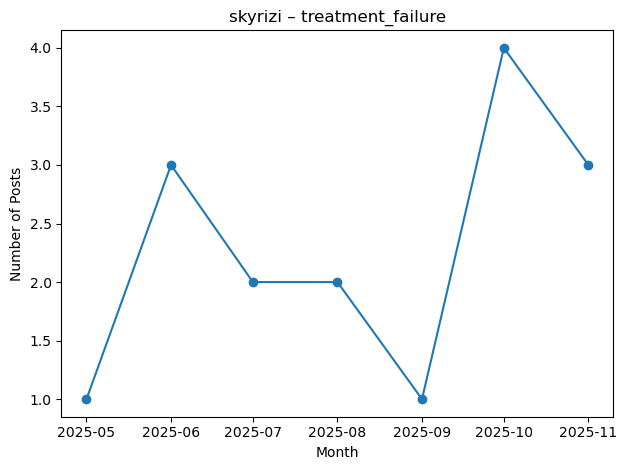

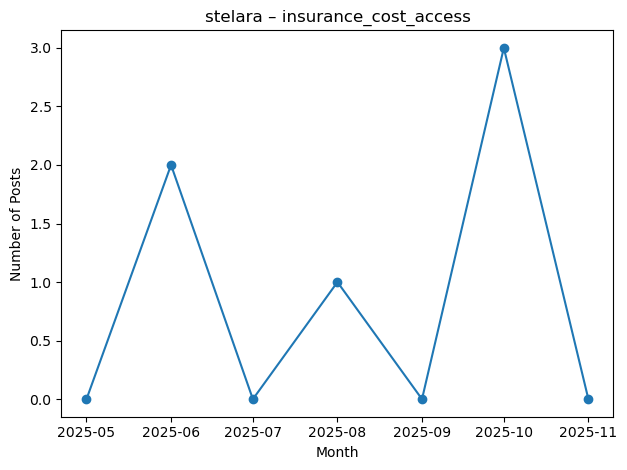

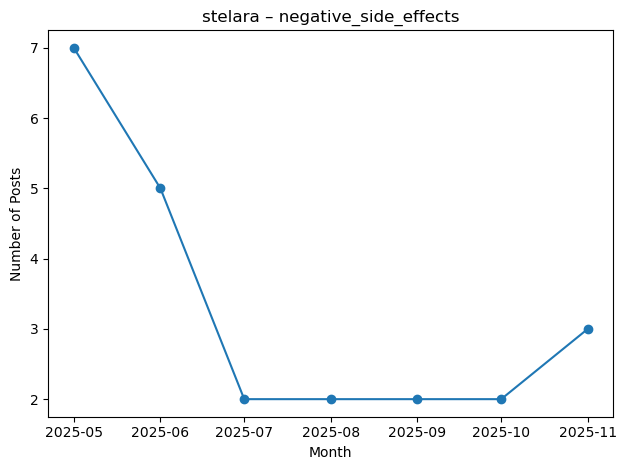

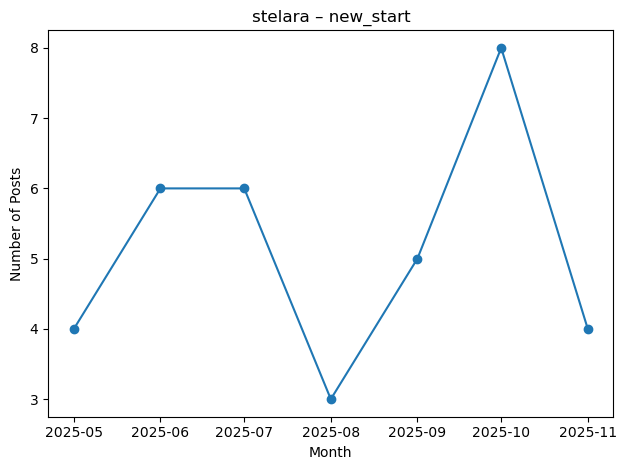

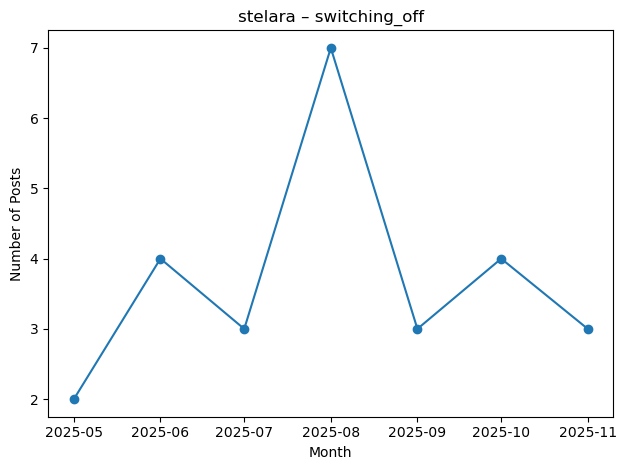

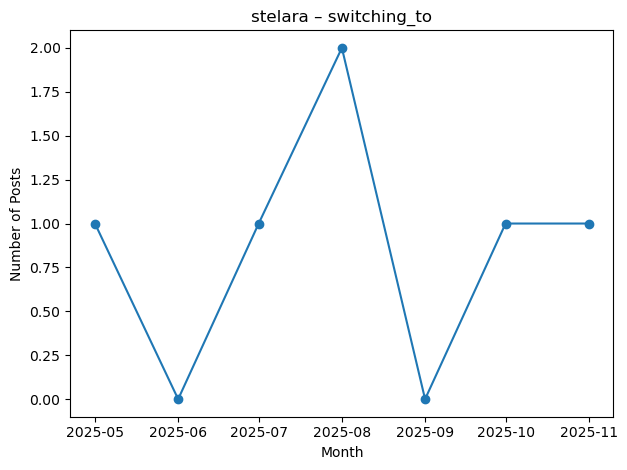

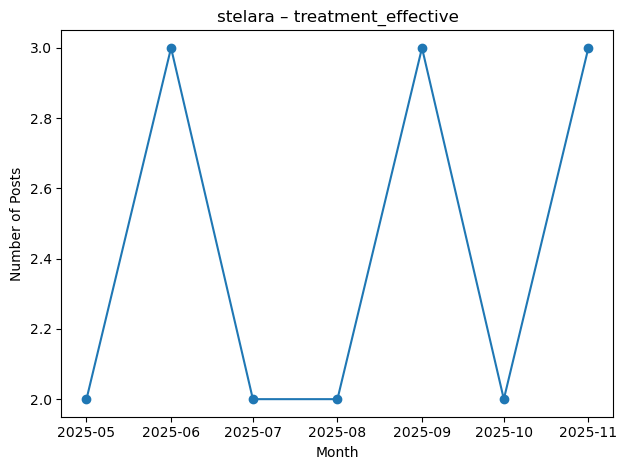

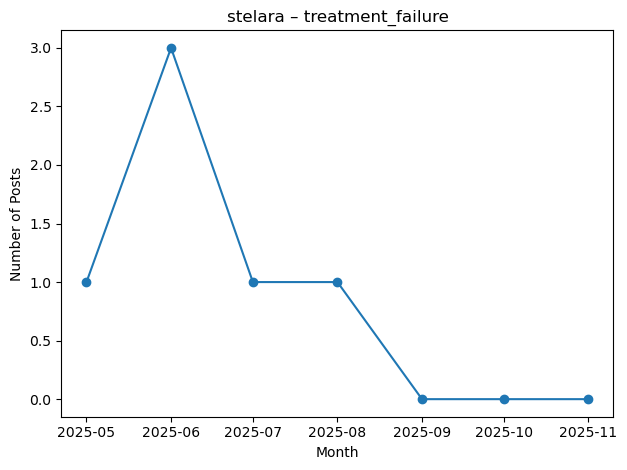

In [ ]:
for (drug, topic), group in filled_df.groupby(['drug', 'topic']):
    plt.plot(group['month'], group['n_posts'], marker='o')

    plt.title(f"{drug} – {topic}")
    plt.xlabel("Month")
    plt.ylabel("Number of Posts")

    plt.tight_layout()


    plt.show()


In [ ]:
#now lets do proportions
filled_df = filled_df.sort_values("month")

tmp = filled_df.groupby(["drug", "month"])["n_posts"].sum().reset_index().rename(columns={"n_posts": "total_posts_drug_month"})

filled_df = filled_df.merge(tmp, on=["drug", "month"], how="left")

In [ ]:
mask = filled_df["total_posts_drug_month"] != 0
filled_df["prop_within_drug"] = None
filled_df.loc[mask, "prop_within_drug"] = filled_df.loc[mask, "n_posts"] / filled_df.loc[mask, "total_posts_drug_month"]

In [ ]:
filled_df.head()

,drug,topic,month,n_posts,total_score,mean_score,total_posts_drug_month,prop_within_drug
0,Humira,insurance_cost_access,2025-05-01,2.0,3.0,1.500000,40.0,0.05
1,stelara,switching_off,2025-05-01,2.0,2.0,1.000000,17.0,0.117647
2,Stelara,treatment_effective,2025-05-01,1.0,3.0,3.000000,16.0,0.0625
3,Skyrizi,new_start,2025-05-01,9.0,34.0,3.777778,28.0,0.321429
4,Stelara,treatment_failure,2025-05-01,9.0,27.0,3.000000,16.0,0.5625


In [ ]:
for (drug, topic), group in filled_df.groupby(['drug', 'topic']):
    plt.plot(group['month'], group['prop_within_drug'], marker='o')

    plt.title(f"{drug} – {topic}")
    plt.xlabel("Month")
    plt.ylabel("Post Prop")


    plt.grid(True)

    plt.show()


In [ ]:
filled_df["drug_topic"] = filled_df["drug"] + "_" + filled_df["topic"]

In [ ]:
filled_df.head()

,drug,topic,month,n_posts,total_score,mean_score,total_posts_drug_month,prop_within_drug,drug_topic
0,Humira,insurance_cost_access,2025-05-01,2.0,3.0,1.500000,40.0,0.05,Humira_insurance_cost_access
1,stelara,switching_off,2025-05-01,2.0,2.0,1.000000,17.0,0.117647,stelara_switching_off
2,Stelara,treatment_effective,2025-05-01,1.0,3.0,3.000000,16.0,0.0625,Stelara_treatment_effective
3,Skyrizi,new_start,2025-05-01,9.0,34.0,3.777778,28.0,0.321429,Skyrizi_new_start
4,Stelara,treatment_failure,2025-05-01,9.0,27.0,3.000000,16.0,0.5625,Stelara_treatment_failure


In [ ]:
#correlations with p value

In [ ]:
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

In [ ]:
dfp = filled_df.pivot_table(index="month", columns="drug_topic", values="prop_within_drug", fill_value=0).sort_index()

In [ ]:
lags = [0, 1, 2]
cols = dfp.columns.tolist()
results = []

for a in cols:
    for b in cols:
        if a != b:
            for lag in lags:
                if lag > 0:
                    y = dfp[b].shift(lag)
                else:
                    y = dfp[b]

                x = dfp[a]

                combined = pd.concat([x, y], axis=1).dropna()

                if len(combined) >= 3:
                    r, p = spearmanr(combined.iloc[:, 0], combined.iloc[:, 1])
                else:
                    r, p = np.nan, np.nan

                results.append({
                    "series_a": a,
                    "series_b": b,
                    "lag": lag,
                    "n_points": len(combined),
                    "spearman_r": r,
                    "p_value": p
                })

lagged_corr = pd.DataFrame(results)

mask = lagged_corr["p_value"].notna()
pvals = lagged_corr.loc[mask, "p_value"].values

rej_fdr, pvals_fdr, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")
lagged_corr.loc[mask, "p_fdr_bh"] = pvals_fdr
lagged_corr.loc[mask, "reject_fdr_bh"] = rej_fdr

rej_bonf, pvals_bonf, _, _ = multipletests(pvals, alpha=0.05, method="bonferroni") #extra tough
lagged_corr.loc[mask, "p_bonf"] = pvals_bonf
lagged_corr.loc[mask, "reject_bonf"] = rej_bonf

lagged_corr["reject_fdr_bh"] = lagged_corr["reject_fdr_bh"].fillna(False)
lagged_corr["p_fdr_bh"] = lagged_corr["p_fdr_bh"].fillna(np.inf)

/var/folders/pf/s92c2ky926x94g0fv3rkqb8r0000gn/T/ipykernel_51115/2036570609.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .pivot_table(index="month", columns="drug_topic", values="prop_within_drug", fill_value=0)
/var/folders/pf/s92c2ky926x94g0fv3rkqb8r0000gn/T/ipykernel_51115/2036570609.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = spearmanr(combined.iloc[:, 0], combined.iloc[:, 1])
/var/folders/pf/s92c2ky926x94g0fv3rkqb8r0000gn/T/ipykernel_51115/2036570609.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = spearmanr(combined.iloc[:, 0], combined.iloc[:, 1])
/var/folders/pf/s92c2ky926x94g0fv3rkqb8r0000gn/T/ipykernel_51115/2036570609.py:21: C

In [ ]:
lagged_corr[lagged_corr["reject_fdr_bh"]].sort_values("p_fdr_bh") #only significant

,series_a,series_b,lag,n_points,spearman_r,p_value,p_fdr_bh,reject_fdr_bh,p_bonf,reject_bonf
247,Humira_negative_side_effects,humira_insurance_cost_access,1,6,-1.0,0.000000e+00,0.000000e+00,True,0.000000e+00,True
5455,humira_treatment_effective,Humira_switching_off,1,6,1.0,0.000000e+00,0.000000e+00,True,0.000000e+00,True
5005,humira_new_start,Skyrizi_switching_to,1,6,-1.0,0.000000e+00,0.000000e+00,True,0.000000e+00,True
6861,rinvoq_treatment_failure,humira_switching_to,0,7,1.0,2.494476e-40,4.582353e-37,True,2.291177e-36,True
5400,humira_switching_to,rinvoq_treatment_failure,0,7,1.0,2.494476e-40,4.582353e-37,True,2.291177e-36,True
206,Humira_negative_side_effects,Skyrizi_insurance_cost_access,2,5,-1.0,1.404265e-24,4.030681e-22,True,1.289818e-20,True
7793,skyrizi_treatment_effective,Rinvoq_treatment_effective,2,5,-1.0,1.404265e-24,4.030681e-22,True,1.289818e-20,True
7472,skyrizi_switching_off,Skyrizi_negative_side_effects,2,5,-1.0,1.404265e-24,4.030681e-22,True,1.289818e-20,True
7298,skyrizi_new_start,Rinvoq_treatment_effective,2,5,1.0,1.404265e-24,4.030681e-22,True,1.289818e-20,True
6740,rinvoq_treatment_effective,skyrizi_treatment_effective,2,5,1.0,1.404265e-24,4.030681e-22,True,1.289818e-20,True


In [ ]:
series_a = "Humira_switching_to"
series_b = "Stelara_negative_side_effects"

plot_df = (filled_df.loc[filled_df["drug_topic"].isin([series_a, series_b])].sort_values("month"))

plot_pivot = (plot_df.pivot(index="month", columns="drug_topic", values="prop_within_drug").sort_index())

plt.figure(figsize=(10, 5))

plt.plot(plot_pivot.index, plot_pivot[series_a], marker="o", label=series_a)
plt.plot(plot_pivot.index, plot_pivot[series_b], marker="o", label=series_b)

plt.title(f"{series_a} vs {series_b}")
plt.xlabel("Month")
plt.ylabel("Proportion within drug")
plt.legend()
plt.show()

In [ ]:
hi

NameError: name 'hi' is not defined

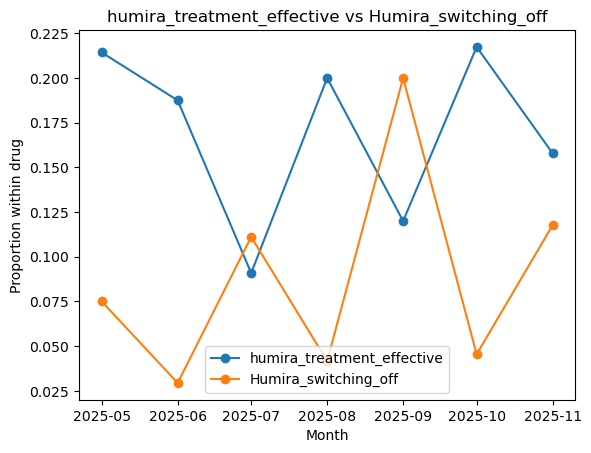

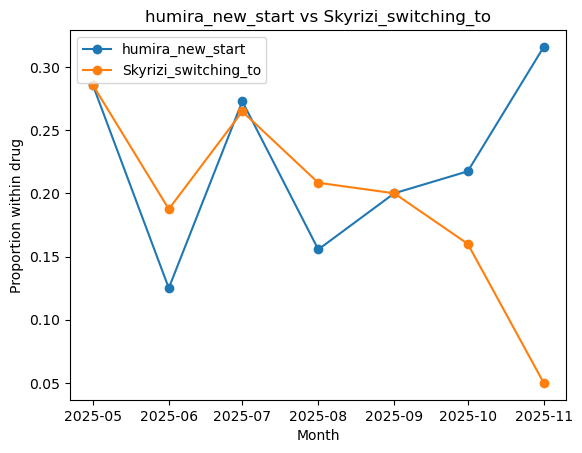

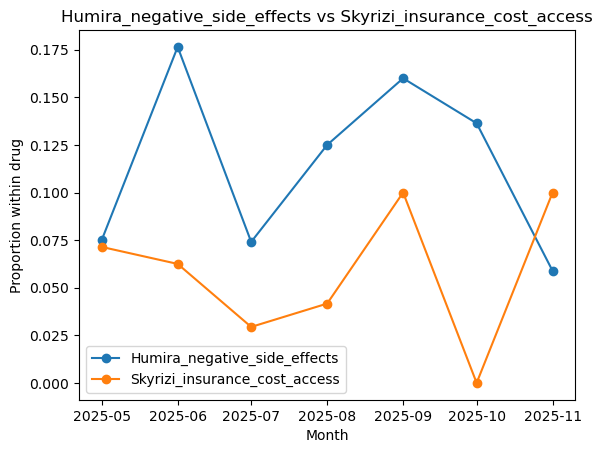

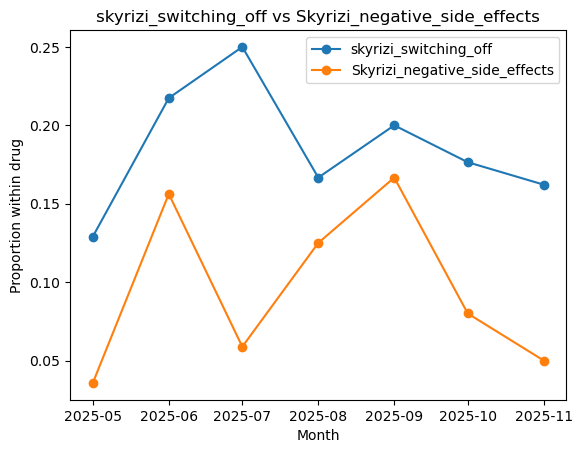

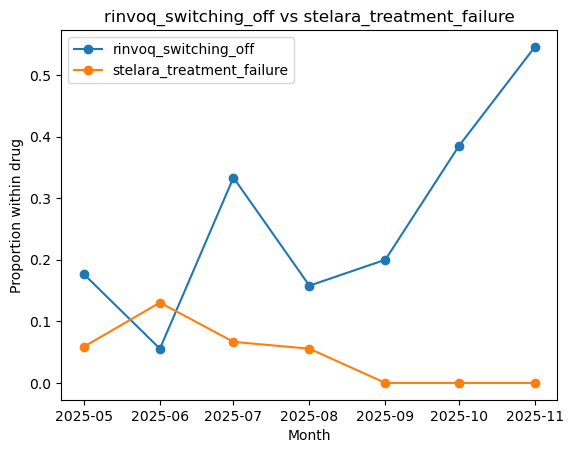

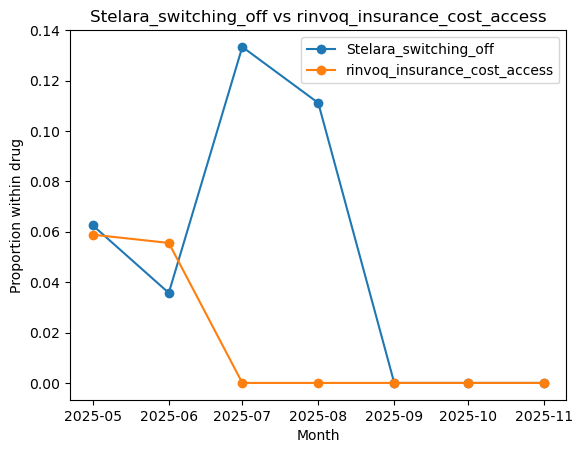

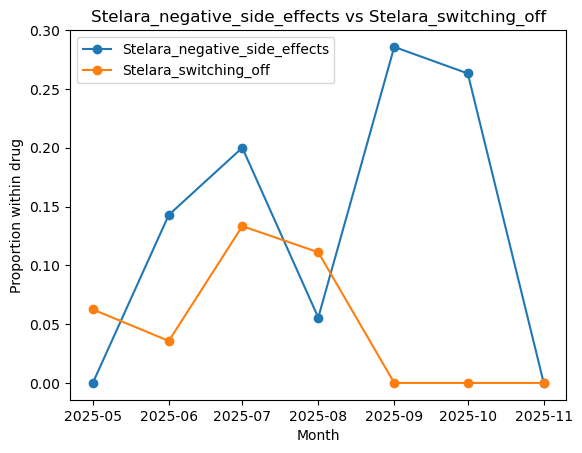

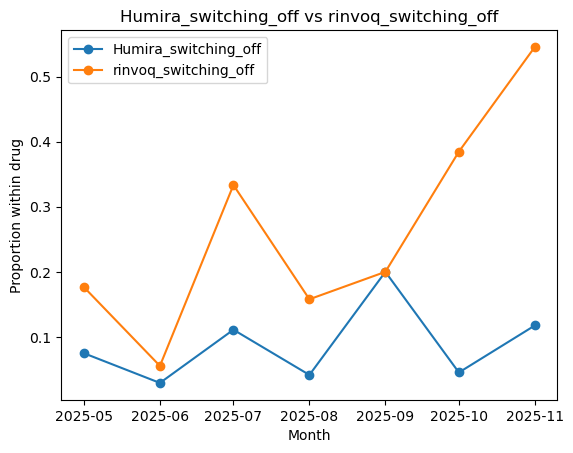

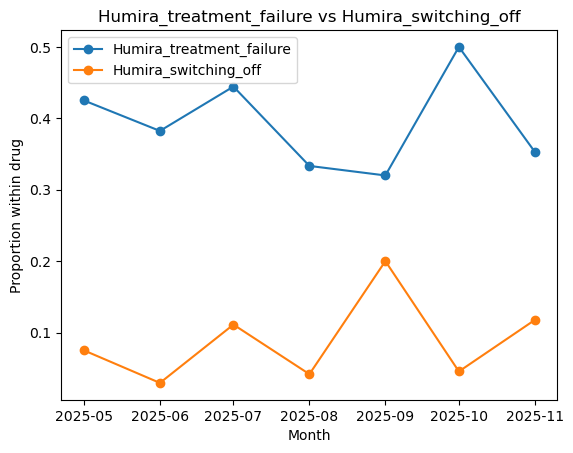

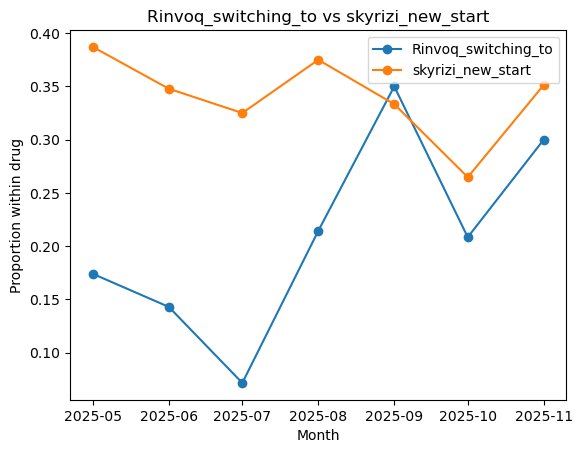

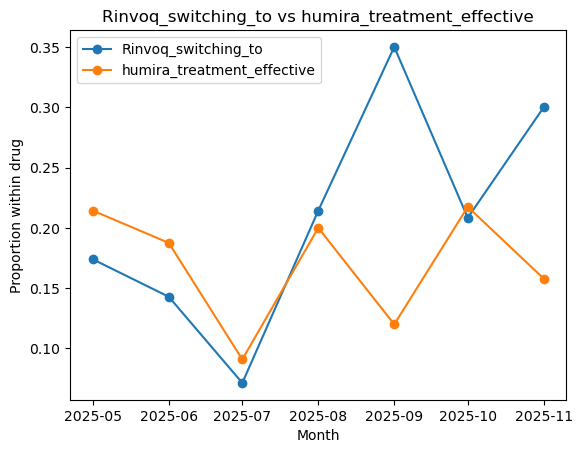

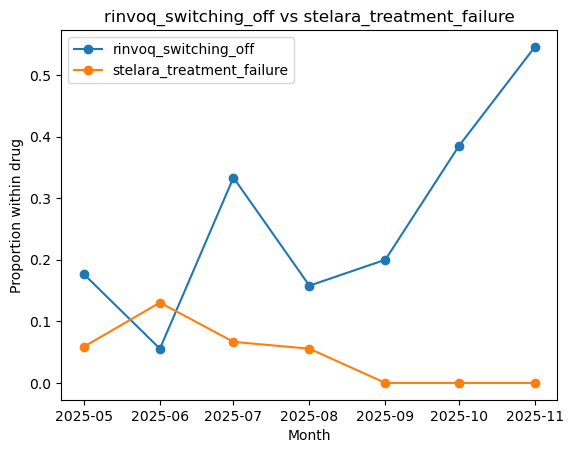

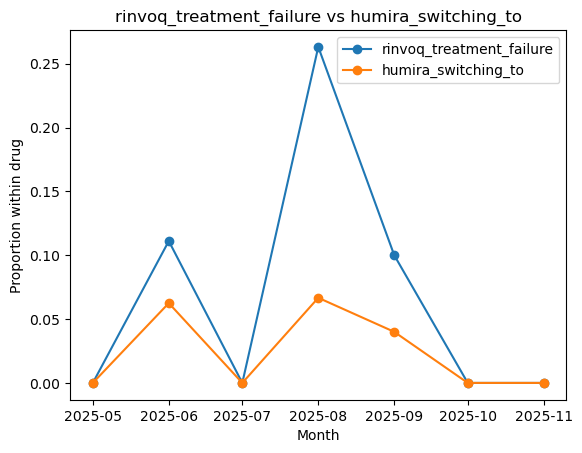

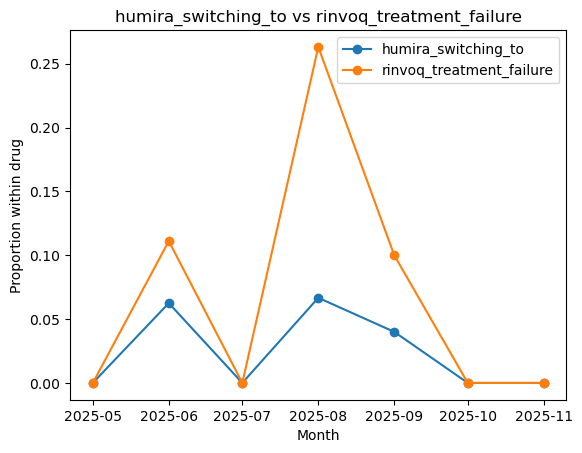

In [ ]:
switching_combos = [
    ("humira_treatment_effective", "Humira_switching_off"),
    ("humira_new_start", "Skyrizi_switching_to"),
    ("Humira_negative_side_effects", "Skyrizi_insurance_cost_access"),
    ("skyrizi_switching_off", "Skyrizi_negative_side_effects"),
    ("rinvoq_switching_off", "stelara_treatment_failure"),
    ("Stelara_switching_off", "rinvoq_insurance_cost_access"),
    ("Stelara_negative_side_effects", "Stelara_switching_off"),
    ("Humira_switching_off", "rinvoq_switching_off"),
    ("Humira_treatment_failure", "Humira_switching_off"),
    ("Rinvoq_switching_to", "skyrizi_new_start"),
    ("Rinvoq_switching_to", "humira_treatment_effective"),
    ("rinvoq_switching_off", "stelara_treatment_failure"),
    ("rinvoq_treatment_failure", "humira_switching_to"),
    ("humira_switching_to", "rinvoq_treatment_failure")
]

for series_a, series_b in switching_combos:
    if series_a not in dfp.columns or series_b not in dfp.columns:
        continue

    subset = dfp[[series_a, series_b]].copy() #dfp from prop makin

    plt.plot(subset.index, subset[series_a], marker="o", label=series_a)
    plt.plot(subset.index, subset[series_b], marker="o", label=series_b)

    plt.title(f"{series_a} vs {series_b}")
    plt.xlabel("Month")
    plt.ylabel("Proportion within drug")
    plt.legend()
    plt.show()




In [ ]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [ ]:
#THIS IS FOR HUMIRA INSURANCE / COST / ACCESS

humira_i = filled_df[filled_df["drug_topic"] == "Humira_insurance_cost_access"].sort_values("month").set_index("month")["n_posts"].astype(float)

                #A,N,N

model_ANN = ETSModel(humira_i, error="add", trend=None, seasonal=None)
fit_ANN = model_ANN.fit(disp=False)

                #A,A,N this has trend

model_AAN = ETSModel(humira_i, error="add", trend="add", seasonal=None)
fit_AAN = model_AAN.fit(disp=False)

time_index = np.arange(len(humira_i))
slope = np.polyfit(time_index, fit_AAN.fittedvalues, 1)[0]

humira_i_result = {
    "n_points": len(humira_ica),
    "AIC_ANN": fit_ANN.aic,
    "AIC_AAN": fit_AAN.aic,
    "Best_model": "AAN" if fit_AAN.aic < fit_ANN.aic else "ANN",
    "slope (from AAN)": slope,
    "trend:": (fit_ANN.aic - fit_AAN.aic) > 2
}

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
humira_ica_result

{'n_points': 7,
 'AIC_ANN': np.float64(21.94852894932097),
 'AIC_AAN': np.float64(25.693955501050375),
 'Best_model': 'ANN',
 'slope (from AAN)': np.float64(0.0714213092322991),
 'trend_present?': np.False_}

In [ ]:
#THIS IS FOR HUMIRA TREATMENT FAILURE

humira_t = filled_df[filled_df["drug_topic"] == "Humira_treatment_failure"].sort_values("month").set_index("month")["n_posts"].astype(float)

                #A,N,N
model_ANN2 = ETSModel(humira_t, error="add", trend=None, seasonal=None)
fit_ANN2 = model_ANN2.fit(disp=False)

                #A,A,N
model_AAN2 = ETSModel(humira_t, error="add", trend="add", seasonal=None)
fit_AAN2 = model_AAN2.fit(disp=False)

time_index2 = np.arange(len(humira_t))
slope2 = np.polyfit(time_index2, fit_AAN2.fittedvalues, 1)[0]

humira_t_result = {
    "n_points": len(humira_t),
    "AIC_ANN": fit_ANN2.aic,
    "AIC_AAN": fit_AAN2.aic,
    "Best_model": "AAN" if fit_AAN2.aic < fit_ANN2.aic else "ANN",
    "slope (from AAN)": slope2,
    "trend:": (fit_ANN2.aic - fit_AAN2.aic) > 2
}

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
humira_t_result

{'n_points': 7,
 'AIC_ANN': np.float64(41.549191313199984),
 'AIC_AAN': np.float64(38.3114835871252),
 'Best_model': 'AAN',
 'slope (from AAN)': np.float64(-1.4643239319101118),
 'trend:': np.True_}

In [ ]:
humira_t_train = humira_t.iloc[:-1]
humira_t_actual = humira_t.iloc[-1]
last_month = humira_t.index[-1]

model_forecast = ETSModel(humira_t_train, error="add", trend= "add", seasonal=None)
fit_forecast = model_forecast.fit(disp=False)

forecast = fit_forecast.forecast(steps=1)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
forecast

2025-11-01    6.599998
Freq: MS, dtype: float64

In [ ]:
humira_t_actual

np.float64(6.0)

In [ ]:
abs_error = abs(forecast.iloc[0] - humira_t_actual)
percent_error = (abs_error / humira_t_actual) * 100 if humira_t_actual != 0 else np.nan

In [ ]:
abs_error

np.float64(0.5999983386892334)

In [ ]:
percent_error

np.float64(9.999972311487221)